# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **Outlier exposure with Energy-bounded Learning**

In this HW, **you need to fill in the blanks by referring to the lecture note for energy-based learning.**
Then, test the following three anomaly scores for outlier exposure.
Submit the completed code with ROC-AUC curves & anomaly score histograms for these three cases (no discussion is required).

(1) 1- MSP(Maximum softmax probability)

(2) Cross entropy H with respect to the uniform probability ($-H(\mathcal{U}; f(\mathbf{x};\theta))$, where $f(\mathbf{x};\theta))$ is the logit from the model.

(3) Energy scores ($ E(\mathbf{x};\theta) := -T \cdot \mathrm{log}\sum_{k=1}^{K} e^{f_k (\mathbf{x};\theta)/T}$), where $f_k (\mathbf{x};\theta)$ is the logit output corresponding to the label $k$ and $T$ is the temperature scaling parameter.
Note that the negative energy score is used as the anomaly score. Accordingly, higher energy activation corresponds to inliers, whereas lower energy activation denotes outliers.

In this code, the model is trained with the following objectives

$\min _\theta \mathbb{E}_{(\mathbf{x}, k) \sim \mathcal{D}_{\text {in }}^{\text {train }}}\left[-\log F_k(\mathbf{x}; \theta)\right]+\lambda \cdot L_{\text {energy }}$

where $F_k(\mathbf{x};\theta)$ is the softmax output. The energy loss $L_{\text {energy }}$ is given by

$\begin{aligned}
L_{\text {energy }} & =\mathbb{E}_{\left(\mathbf{x}_{\text {in }}, y\right) \sim \mathcal{D}_{\mathrm{in}}^{\text {train }}}\left(\max \left(0, E\left(\mathbf{x}_{\text {in }}\right)-m_{\text {in }}\right)\right)^2
 +\mathbb{E}_{\mathbf{x}_{\text {out }} \sim \mathcal{D}_{\text {out }}^{\text {train }}}\left(\max \left(0, m_{\text {out }}-E\left(\mathbf{x}_{\text {out }}\right)\right)\right)^2
\end{aligned} $

The energy loss penalizes when the inlier's energy is higher than $m_{in}$ and when the outlier's energy is lower than $m_{out}$.


## 1. Import packages
New library imported for this project:
- `Scikit-learn` package: includes useful tools for data analysis & preprocessing (https://scikit-learn.org/stable/)
  - We use this package for `anomaly score` metrics
- `Matplot` library: for plotting graphs
- `Torchinfo`: summarizes and print formatted `model information`

In [1]:
try:
    from torchinfo import summary
except ModuleNotFoundError: # We install the package if necessary
    !pip install torchinfo # install torchinfo module
    from torchinfo import summary
# !pip install seaborn

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn import metrics
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [4]:
plt.rc('font', size=20)

## 2. Hyperparameters
You can change the hyperparameter below.
Parameter `ANOMALY_NUM` means which number to set as an anomaly.

Score mode is option to choose which metric will be used as anomaly score. 0 will be 1 - MSP, and 1 will be -H(u;.). That new metric will be introduced later.

In [5]:
EPOCHS = 10                # Number of epochs to train
BATCH = 32                # Minibatch size
ORGCLASS_NUM = 10         # Num of original classes (10: 0 to 9)

ANOMALY_NUM = [7,8,9]     # (list) Digits will be used as anomalous data
NORMAL_NUM =  [0,1,2,3]   # (list) Digits used as normal data
OUTLIER_NUM = [4,5,6]     # (list) Digits used as ouliter

TEMPSC = 1.0              # temperature parameter (for temperature scaling)
LBSMOOTH = 0.0            # label smoothing parameter



The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here digit `0,1,2,3` will be used as `normal data`, and `7,8,9` will be used as `anomaly data`. And `4,5,6` will be used as `outlier exposure data`.
`TEMPSC` and `LBSMOOTH` are parameters for temperature scaling and label smoothing, respectively.

## 3. Dataset and Dataloader

Here we use MNIST dataset.
The datatype of the dataset is a TorchTensor of tuples: (`image tensor`, `target label`)

The dimensions of an image tensor is (`channel`=1, `width`=28, `height` =28)

Here, we use `Subset` package in `torch.utils.data` to build two sub-datasets (validation, test).


In [6]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=False)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=False)

train_idx = [i for i,v in enumerate(mnist_train) if v[1] in NORMAL_NUM]         # get a list of indices with NORMAL_NUM, v is the tuple of (image tensor, label)
train_dataset = Subset(mnist_train,train_idx)                                   # get a subset of dataset using train_idx

testdigit = ANOMALY_NUM + NORMAL_NUM                                            # join two list
test_idx =[i for i,v in enumerate(mnist_test) if v[1] in testdigit]
Num_test = int(len(test_idx)/2)

test_dataset = Subset(mnist_test,test_idx[:Num_test])
val_dataset = Subset(mnist_test,test_idx[Num_test:])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

# this is for outlier exposure

outlier_idx = [i for i,v in enumerate(mnist_train) if v[1] in OUTLIER_NUM]
outlier_dataset = Subset(mnist_train,outlier_idx)
outlier_dataloader = DataLoader(outlier_dataset, batch_size=BATCH, shuffle=True)

Dataset length is like below.

In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
# now print outlier too
print(len(outlier_dataset))

24754
3584
3584
17181


## 4. Define a DNN model
Now, you will use CNN classifier.

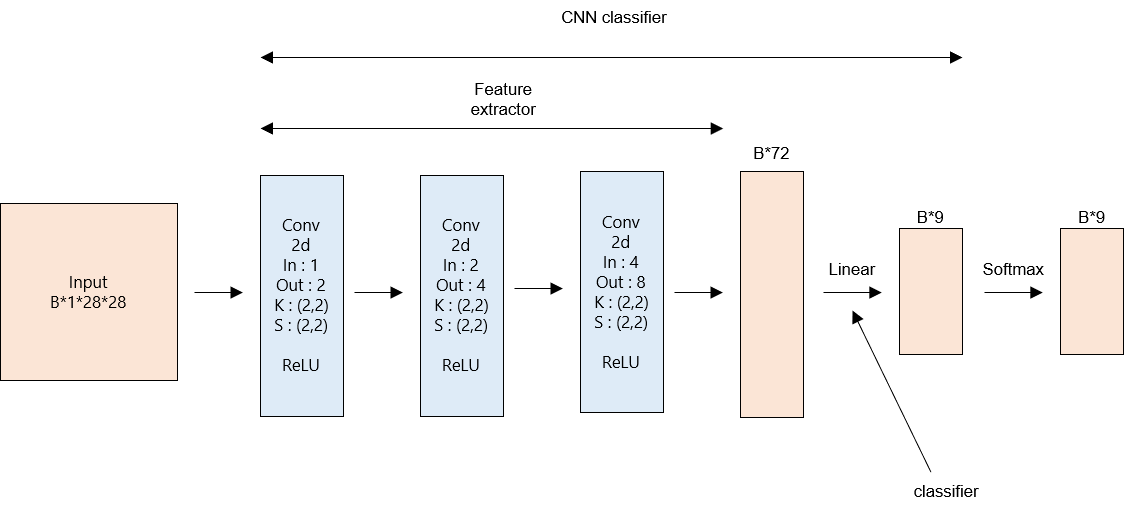

In [8]:
class ClassificationCNNModel(nn.Module):
    def __init__(self, nclass=len(NORMAL_NUM)):
        super(ClassificationCNNModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,2,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(2,4,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(4,8,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(72,nclass),
        )

    def forward(self, x):
        feature = self.feature_extractor(x)
        feature = feature.reshape(feature.shape[0],-1)
        out = self.classifier(feature)
        return out, feature

In [9]:
## Create classification object
model = ClassificationCNNModel(len(NORMAL_NUM)).to(device)
summary(model,input_size=(BATCH,1,28,28)) # summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationCNNModel                   [32, 4]                   --
├─Sequential: 1-1                        [32, 8, 3, 3]             --
│    └─Conv2d: 2-1                       [32, 2, 14, 14]           10
│    └─ReLU: 2-2                         [32, 2, 14, 14]           --
│    └─Conv2d: 2-3                       [32, 4, 7, 7]             36
│    └─ReLU: 2-4                         [32, 4, 7, 7]             --
│    └─Conv2d: 2-5                       [32, 8, 3, 3]             136
│    └─ReLU: 2-6                         [32, 8, 3, 3]             --
├─Sequential: 1-2                        [32, 4]                   --
│    └─Linear: 2-7                       [32, 4]                   292
Total params: 474
Trainable params: 474
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.27

### Loss functions & optimizers & Anomaly Score

Loss function is Cateogrical Cross Entropy. This loss is commonly used for multi-class classification. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

This function gets Softmax probability and a target one-hot vectoras input.

For mode == 0, it will act as you know.

Anomaly score is then calculated in validation and test. 1 - Maximum Softmax Probability is commonly used as an anomaly score when using classification as a pretext task. Since the model has the label of normal only, the model may predict anomaly data as a normal class with lower probability (Under-confident).

For mode == 1, new metric will be used.

Using outlier exposure, model is trained to make uniform distribution when they get non normal data. So, when it gets anomaly data, it will make distribution similar to uniform distribution. Using this property, anomaly score can be designed as -H(u;.) where H is cross categorical entropy and u is uniform distribution.

In [21]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=LBSMOOTH) # CCE

def Escore(logits):
   # Fill in here
   return -TEMPSC * torch.logsumexp(logits/TEMPSC, dim=1)

def loss_E(logits, sgn, margin):
    el = Escore(logits)
    # Fill in here
    # Select only the samples where sgn == 1 (exposed outliers)
    Emax, _ = torch.max(torch.cat([torch.zeros_like(el), sgn*(el - margin)], dim=0), dim=0)

    return torch.pow(Emax,2).mean()

def anomaly_score(logits, mode=0):
    if mode == 0:
        # Confidence-based anomaly score: 1 - max(prob)
        probs = torch.softmax(logits, dim=-1)
        max_probs, _ = probs.max(dim=-1)
        return 1 - max_probs

    elif mode == 1:
        num_classes = logits.shape[-1]
        uniform_probs = 1.0 / num_classes
        probs = torch.softmax(logits.detach().cpu(), dim=-1).numpy()
        ce = np.sum(np.log(probs + 1e-10) * uniform_probs, axis=1)
        return ce

    else:
        return Escore(logits)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam as optimizer

## 5. Pretraining for identifying energy score range
First, we design a pretrain model. The pretrain model is trained to classify data using the cross entropy loss. After the training, the energy scores of the pretrained model for the normal and outlier data is evaluated, which become the reference for determining the threshold of energy score training.

In [11]:
def pretrain(dataloader, outlier_dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    losses = []
    E_in = []
    E_out = []
    batch = 0
    for indist, oedist in zip(dataloader, outlier_dataloader):                   # each dist is tuple of (img, label)

        # unzip tuple

        in_image, in_idx = indist
        oe_image, oe_idx = oedist

        # in distribution dataset (normal data)
        logits, _ = model(in_image.to(device))  # logits for normal data # logit (batch, class)
        ein =  Escore(logits)
        E_in.extend(ein.cpu().detach().tolist())

        # Outlier Exposure
        outlier_logits, _ = model(oe_image.to(device))  # logits for outlier data
        eout = Escore(outlier_logits)
        E_out.extend(eout.cpu().detach().tolist())

        # Classification loss over normal data
        p = F.one_hot(in_idx,ORGCLASS_NUM)[:,NORMAL_NUM]
        p = p.float().to(device)
        loss = loss_fn(logits, p)  # cross entropy loss
        losses.append(loss.cpu().detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * logits.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Escore: {np.mean(E_in):>3f},{np.mean(E_out):>3f} ")
        batch += 1
    
    return np.mean(losses), np.mean(E_in), np.mean(E_out)

In [12]:
for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss, Ein, Eout = pretrain(train_dataloader, outlier_dataloader, model, loss_fn, optimizer)


Epoch 1
-------------------------------
loss: 1.387566  [    0/24754]
Escore: -1.328743,-1.329036 
loss: 0.265702  [ 9600/24754]
Escore: -1.799845,-1.415791 
Epoch 2
-------------------------------
loss: 0.099021  [    0/24754]
Escore: -3.907746,-2.019064 
loss: 0.220882  [ 9600/24754]
Escore: -4.225260,-2.144687 
Epoch 3
-------------------------------
loss: 0.134628  [    0/24754]
Escore: -5.043009,-2.167759 
loss: 0.344447  [ 9600/24754]
Escore: -4.735522,-2.362147 
Epoch 4
-------------------------------
loss: 0.080779  [    0/24754]
Escore: -4.810767,-2.861202 
loss: 0.218953  [ 9600/24754]
Escore: -5.153982,-2.427179 
Epoch 5
-------------------------------
loss: 0.162118  [    0/24754]
Escore: -5.238969,-2.373794 
loss: 0.149531  [ 9600/24754]
Escore: -5.188792,-2.438407 
Epoch 6
-------------------------------
loss: 0.132969  [    0/24754]
Escore: -5.309385,-2.420607 
loss: 0.080719  [ 9600/24754]
Escore: -5.360054,-2.505977 
Epoch 7
-------------------------------
loss: 0.2323

### Train
First, set the margin of the hinge loss for energy score training.

In [13]:
MI = -10.0                 # margin for inlier data
MO = -1.0                  # margin for outlier data

In [14]:
def train(dataloader, outlier_dataloader, model, loss_fn, optimizer): # Here, outlier_dataloader is added. Due to this, more GPU memory is used and this is one of the defect of Outlier Exposure.
    model.train()
    size = len(dataloader.dataset)
    losses = []
    E_in = []
    E_out = []
    batch = 0
    for indist, oedist in zip(dataloader, outlier_dataloader):                   # each dist is tuple of (img, label)

        # unzip tuple
        in_image, in_idx = indist
        oe_image, oe_idx = oedist

        # in distribution dataset (normal data)
        logits, _ = model(in_image.to(device))                     # Fill in here
        ein = loss_E(logits, 1, MI)                          # Fill in here
        E_in.extend(Escore(logits).cpu().detach().squeeze().tolist())

        # OE
        outlier_logits, _ = model(oe_image.to(device))             # Fill in here
        eout = loss_E(outlier_logits, -1, MO)                          # Fill in here
        E_out.extend(Escore(outlier_logits).cpu().detach().squeeze().tolist())

        # joint training
        p = F.one_hot(in_idx,ORGCLASS_NUM)[:,NORMAL_NUM]
        p = p.float().to(device)
        closs = loss_fn(logits, p)
        eloss = 0.001*(ein + eout)
        loss = closs + eloss                          # Fill in here
        losses.append(closs.cpu().detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            closs_, current = closs.item(), batch * logits.shape[0]
            print(f"loss: {closs_:>7f}, {eloss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Escore: {np.mean(E_in):>3f},{np.mean(E_out):>3f} ")
        batch += 1

    return np.mean(losses), np.mean(E_in), np.mean(E_out)

Anomaly score is calculated over validation and test datasets. Since the model is trained with normal data, the model may not classify anomaly data with high confidence, so the anomaly score of anomaly data will be higher than the anomaly score of normal data. Using difference in anomaly score distributions, ROC-AUC (Area Under Curve) can be calculated.

### Test

In [15]:
def test(dataloader, model, loss_fn, anomaly_score, valid_mode = True,  draw_mode = False, OE_mode = False, mode=0): # OE_mode is added to collect feature of OE.
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]
    outfeature = []
    total_labels = []

    with torch.no_grad():

        for Imgs, labels in dataloader:

            Imgs = Imgs.to(device)                    # upload to GPU
            logits, features = model(Imgs)            # logits out (idx,class), features out (idx, num_feature )

            if not valid_mode:
                outfeature.append(features)              # append features to tensor list for t-SNE plot
                total_labels.append(labels)

            score = anomaly_score(logits.detach(), mode)            # anomaly score (idx)

            # We do nothing if label does not belong to NORMAL_NUM or ANOMALY_NUM
            for idata in range(logits.shape[0]):
                score_ = score[idata].item()
                if labels[idata] in NORMAL_NUM:  # for normal data
                    # record scores
                    y_true.append(0.)
                    y_pred.append(score_)
                    normal_scores.append(score_)

                elif labels[idata] in ANOMALY_NUM: # for abnormal data
                    y_true.append(1.)
                    y_pred.append(score_)
                    anomaly_scores.append(score_)
        if not OE_mode:
          roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')

    if not OE_mode:
      print(f'AUC: {roc_auc:>0.3f}')

    if not valid_mode:
      outfeature = torch.cat(outfeature, dim=0).cpu().numpy()
      total_labels = torch.cat(total_labels, dim=0).cpu().numpy()

    if not OE_mode:
      return roc_auc.item(), normal_scores, anomaly_scores, outfeature, total_labels
    elif OE_mode:
      return outfeature, total_labels

## 6. Run Trainer
Now all the classes are defined. Let's see how classification loss and AUC changes during training.

Loss is calculated during train, and AUC is calculated during validation.

In [16]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

in_losses = []
oe_losses = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss, in_loss, oe_loss = train(train_dataloader, outlier_dataloader, model, loss_fn, optimizer)
    auc, val_normal_score, val_anomaly_score, _, _ = test(val_dataloader, model, loss_fn, anomaly_score, valid_mode=True)

    train_losses.append(train_loss)
    in_losses.append(in_loss)
    oe_losses.append(oe_loss)

    val_normal_scores.append(np.mean(val_normal_score))
    val_anomaly_scores.append(np.mean(val_anomaly_score))

    roc_auc.append(auc)

    if auc > best_auc:
        best_model,  best_auc = model,  auc

Epoch 1
-------------------------------
loss: 0.136795, 0.144885  [    0/24754]
Escore: -6.214585,-3.228187 
loss: 0.019211, 0.067933  [ 9600/24754]
Escore: -6.845190,-3.743962 
AUC: 0.936
Epoch 2
-------------------------------
loss: 0.025503, 0.064689  [    0/24754]
Escore: -7.778900,-4.573724 
loss: 0.077642, 0.060556  [ 9600/24754]
Escore: -7.561973,-4.356573 
AUC: 0.936
Epoch 3
-------------------------------
loss: 0.030609, 0.052866  [    0/24754]
Escore: -8.185936,-4.163502 
loss: 0.035158, 0.064633  [ 9600/24754]
Escore: -7.753894,-4.292657 
AUC: 0.924
Epoch 4
-------------------------------
loss: 0.059470, 0.066625  [    0/24754]
Escore: -7.556541,-4.372199 
loss: 0.110536, 0.049890  [ 9600/24754]
Escore: -7.800315,-4.218388 
AUC: 0.941
Epoch 5
-------------------------------
loss: 0.051710, 0.065594  [    0/24754]
Escore: -7.465923,-4.039528 
loss: 0.132472, 0.060030  [ 9600/24754]
Escore: -8.031881,-4.192377 
AUC: 0.947
Epoch 6
-------------------------------
loss: 0.025292,

#### Plot train results

<Figure size 640x480 with 0 Axes>

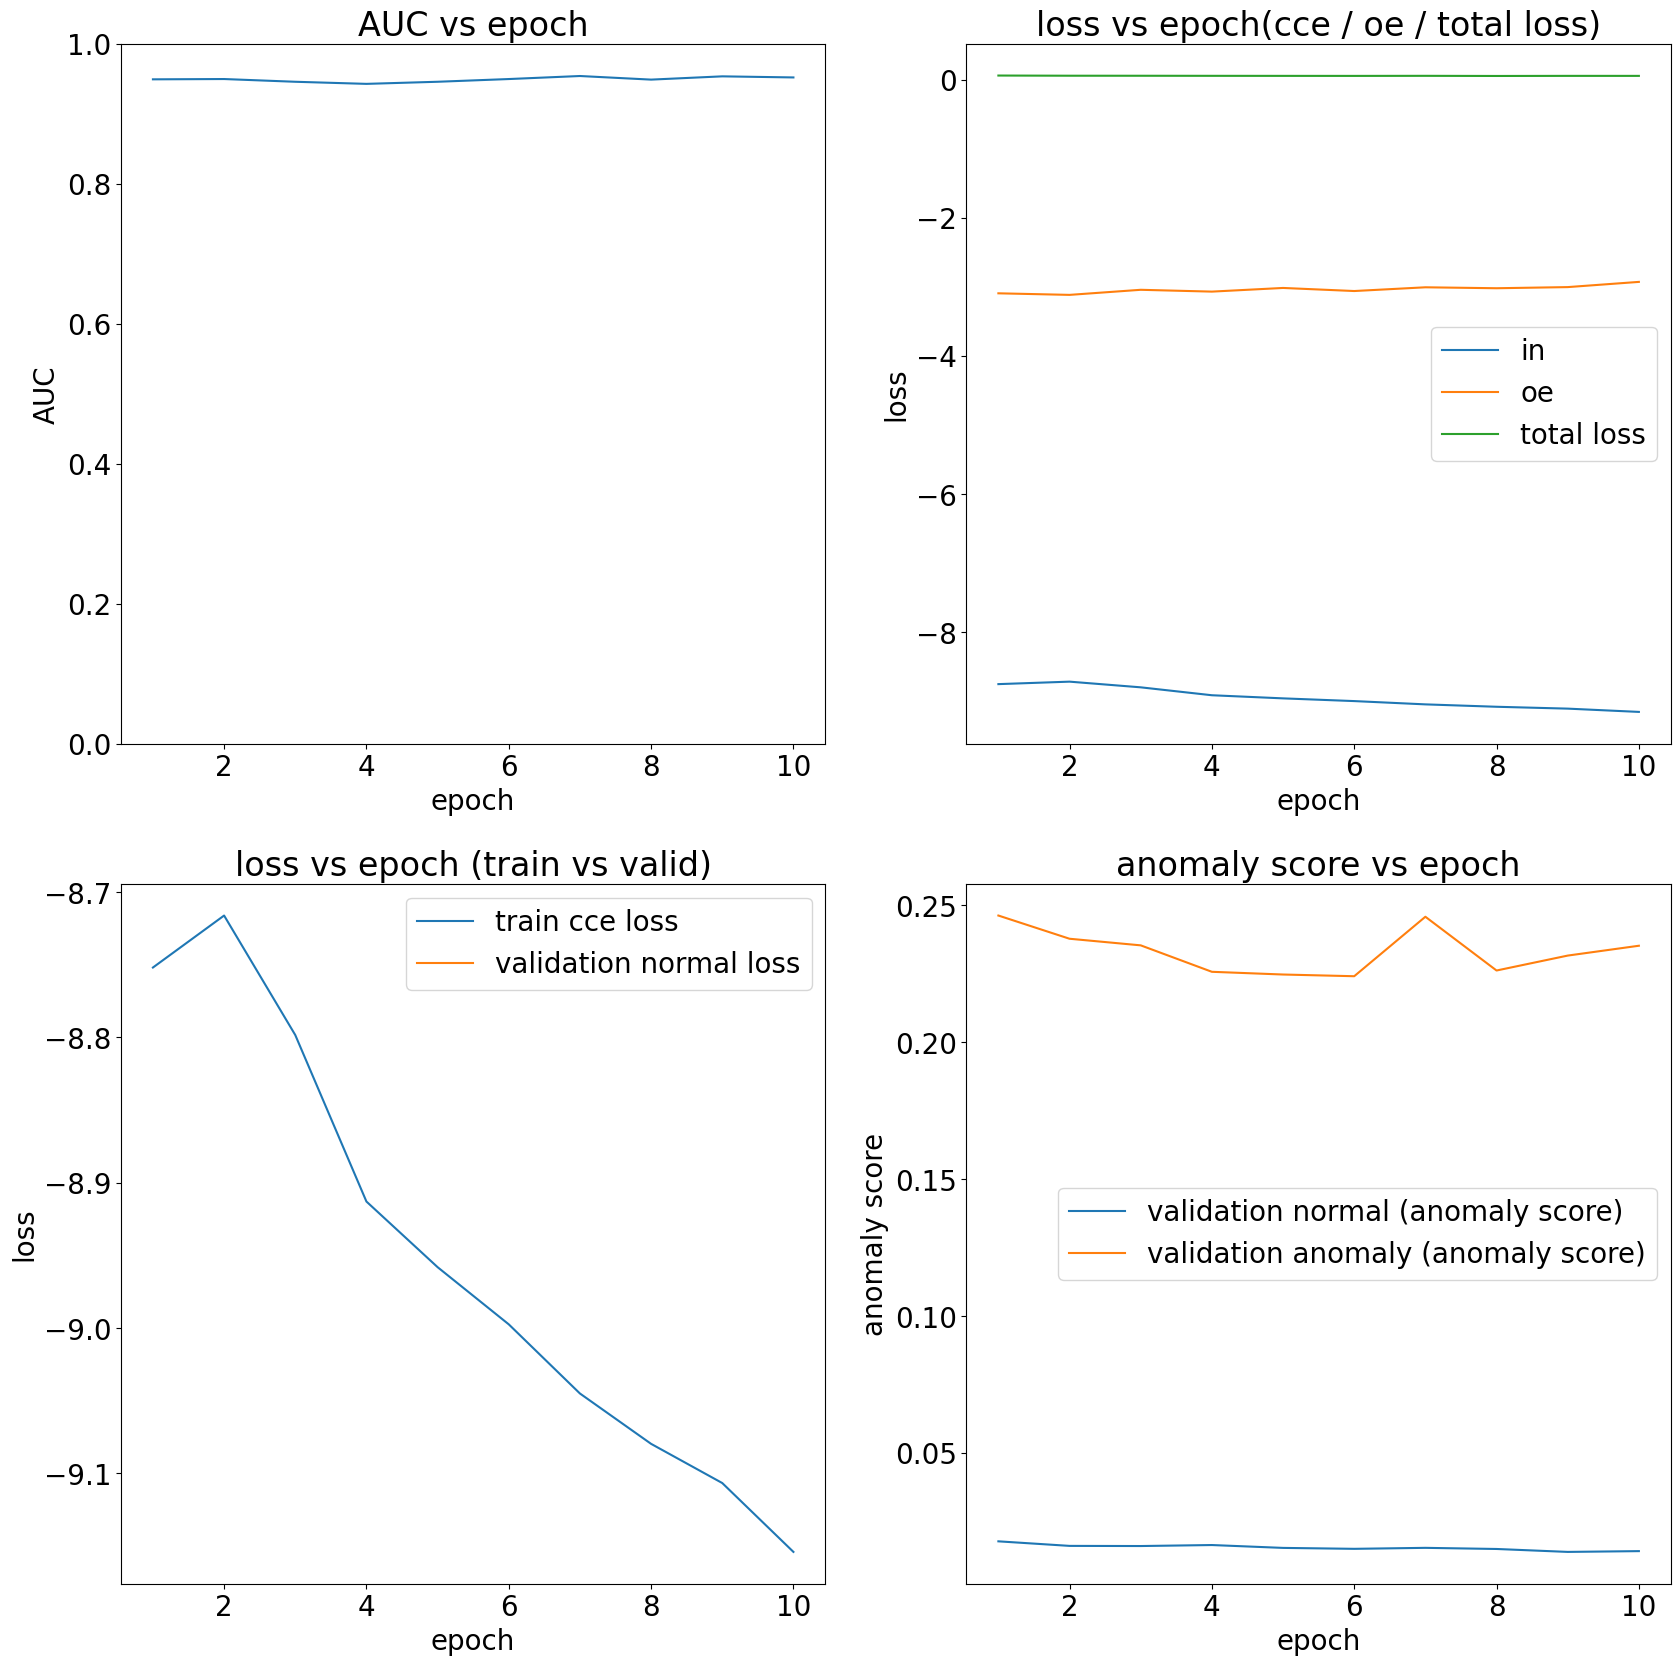

In [21]:
plt.clf()
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(2,2,2)
plt.plot(list(range(1,len(in_losses)+1)),in_losses)
plt.plot(list(range(1,len(oe_losses)+1)),oe_losses)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch(cce / oe / total loss)')
plt.legend(['in', 'oe', 'total loss'])

plt.subplot(2,2,3)
plt.plot(list(range(1,len(in_losses)+1)),in_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch (train vs valid)')
plt.legend(['train cce loss', 'validation normal loss'])

plt.subplot(2,2,4)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal (anomaly score)','validation anomaly (anomaly score)'])

## 7. Performance on test data.
### 7-1. ROC-AUC

AUC: 0.899


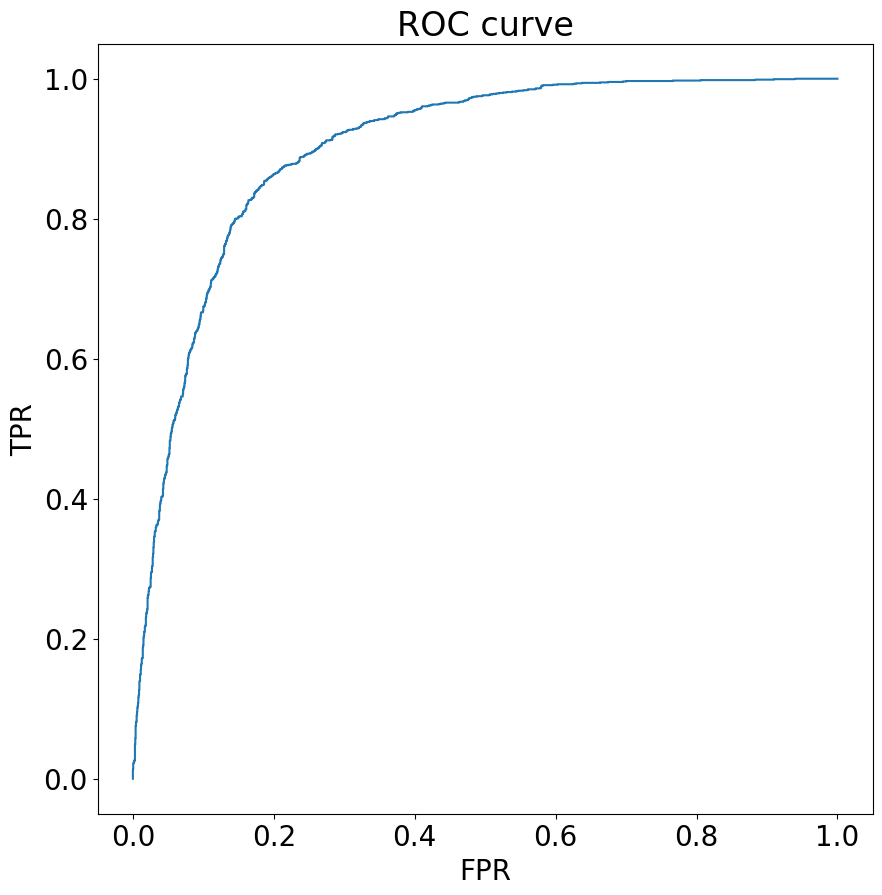

In [27]:
test_auc1, test_normal_scores1, test_anomaly_scores1, best_features1, total_labels1 \
= test(test_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=True, mode=0)

# this is for OE features
oe_features1, oe_labels1 = test(outlier_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=False, OE_mode = True, mode=0)

AUC: 0.903


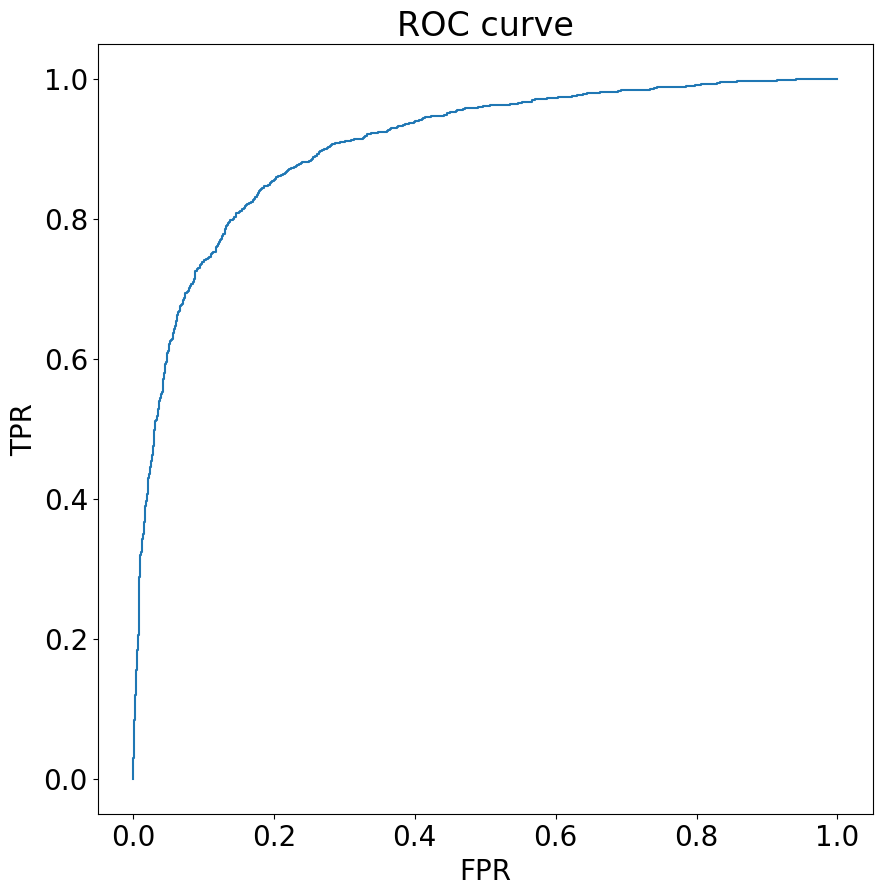

In [31]:
test_auc2, test_normal_scores2, test_anomaly_scores2, best_features2, total_labels2 \
= test(test_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=True, mode=1)

# this is for OE features
oe_features2, oe_labels2 = test(outlier_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=False, OE_mode = True, mode=1)

AUC: 0.930


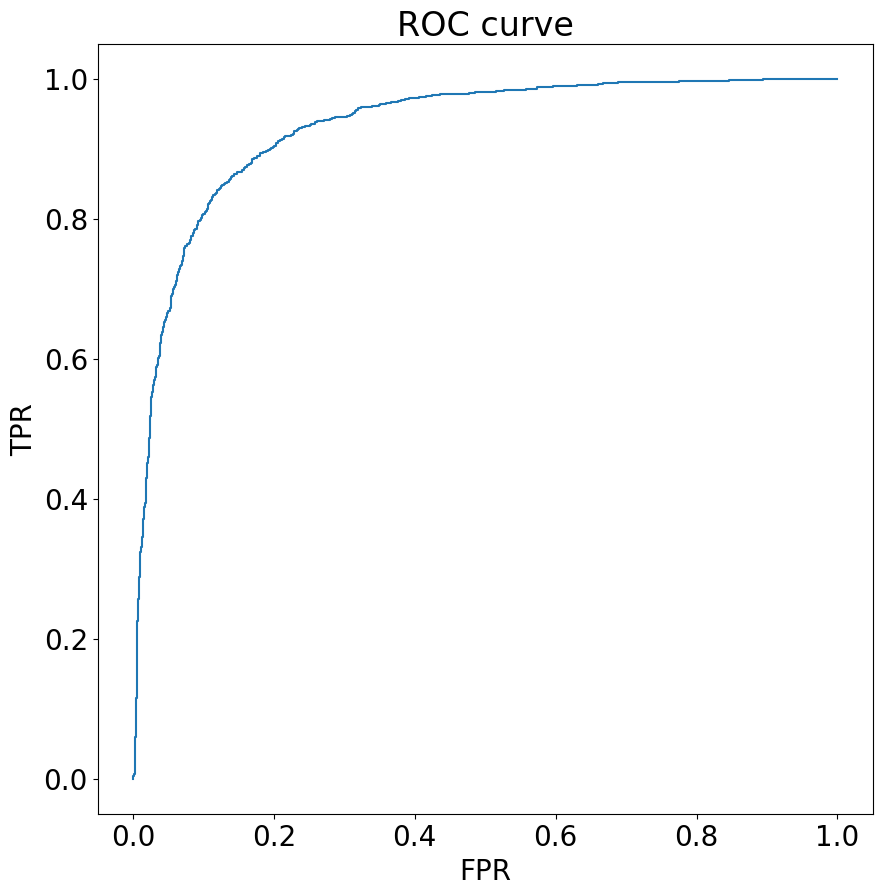

In [30]:
test_auc3, test_normal_scores3, test_anomaly_scores3, best_features3, total_labels3 \
= test(test_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=True, mode=2)

# this is for OE features
oe_features3, oe_labels3 = test(outlier_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=False, OE_mode = True, mode=2)

### 7-2. Histogram of anomaly score

<Figure size 1000x1000 with 0 Axes>

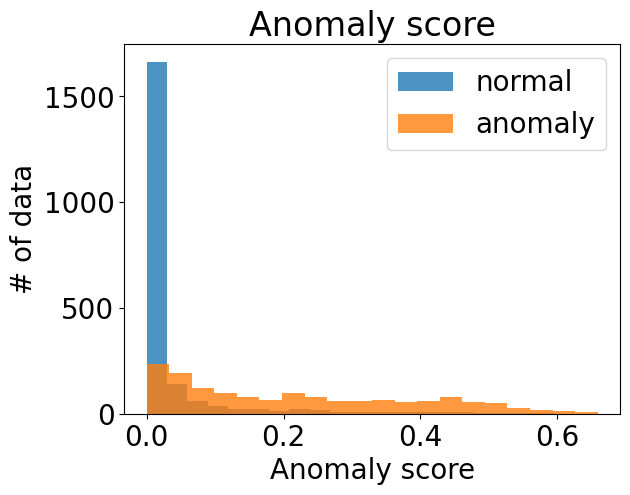

<Figure size 1000x1000 with 0 Axes>

In [28]:
#@title 기본 제목 텍스트
plt.hist(test_normal_scores1,  bins = 20, alpha = 0.8) # 'bins' are related to the number of bins.
plt.hist(test_anomaly_scores1, bins = 20, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

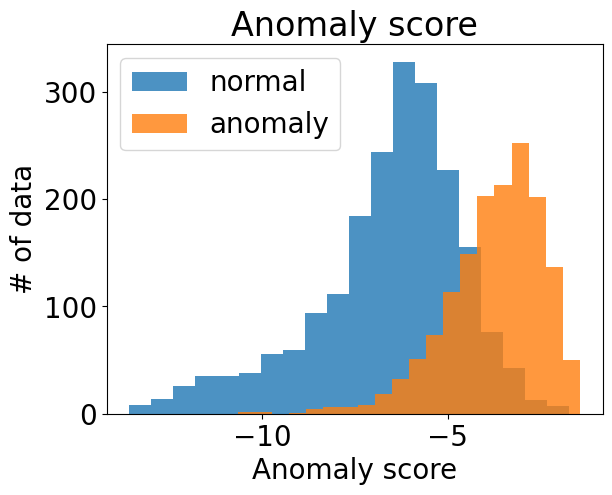

<Figure size 1000x1000 with 0 Axes>

In [32]:
#@title 기본 제목 텍스트
plt.hist(test_normal_scores2,  bins = 20, alpha = 0.8) # 'bins' are related to the number of bins.
plt.hist(test_anomaly_scores2, bins = 20, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

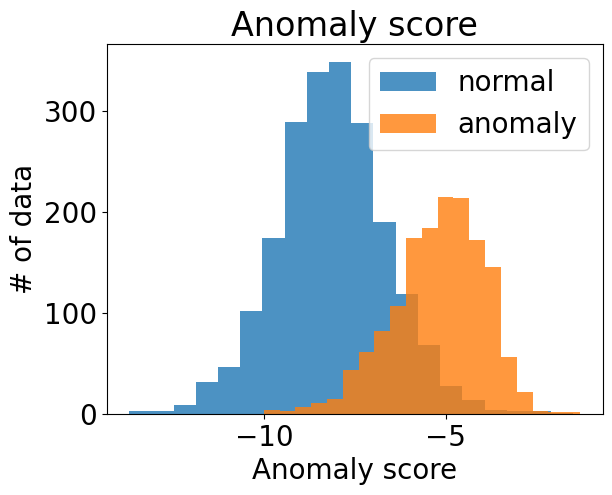

<Figure size 1000x1000 with 0 Axes>

In [33]:
#@title 기본 제목 텍스트
plt.hist(test_normal_scores3,  bins = 20, alpha = 0.8) # 'bins' are related to the number of bins.
plt.hist(test_anomaly_scores3, bins = 20, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

## 8. Predicted Probability (In dist. vs Out dist)
Below code plots figure of the original input image and energy score.

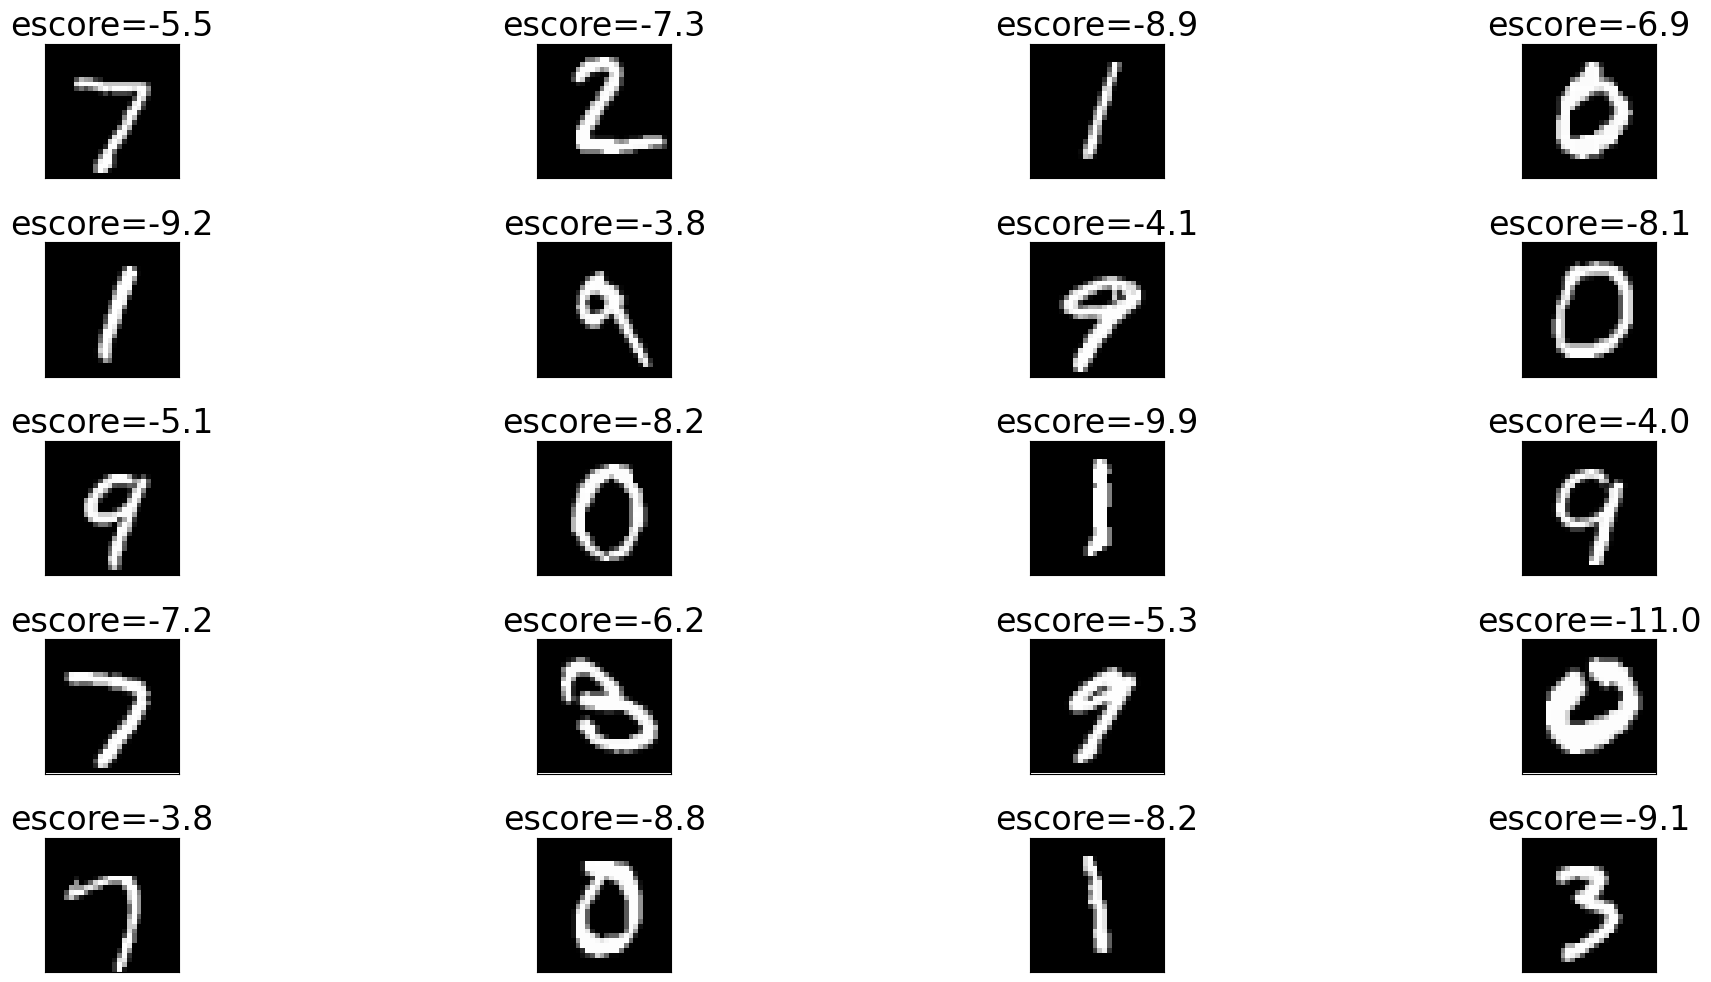

In [34]:
n = 20 # the number of data to be plotted
plt.figure(figsize=(20, 40)) # total figure size

for i in range(n):
    input_image = test_dataset[i][0].to(device)
    pred_escore = Escore(best_model(input_image.unsqueeze(0))[0]).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 4, i+1)
    plt.imshow(input_image[0].cpu()) # show input image
    plt.title(f'escore={pred_escore:>0.1f}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

### Predicted Probability (OE)

For OE, energy score should be high.

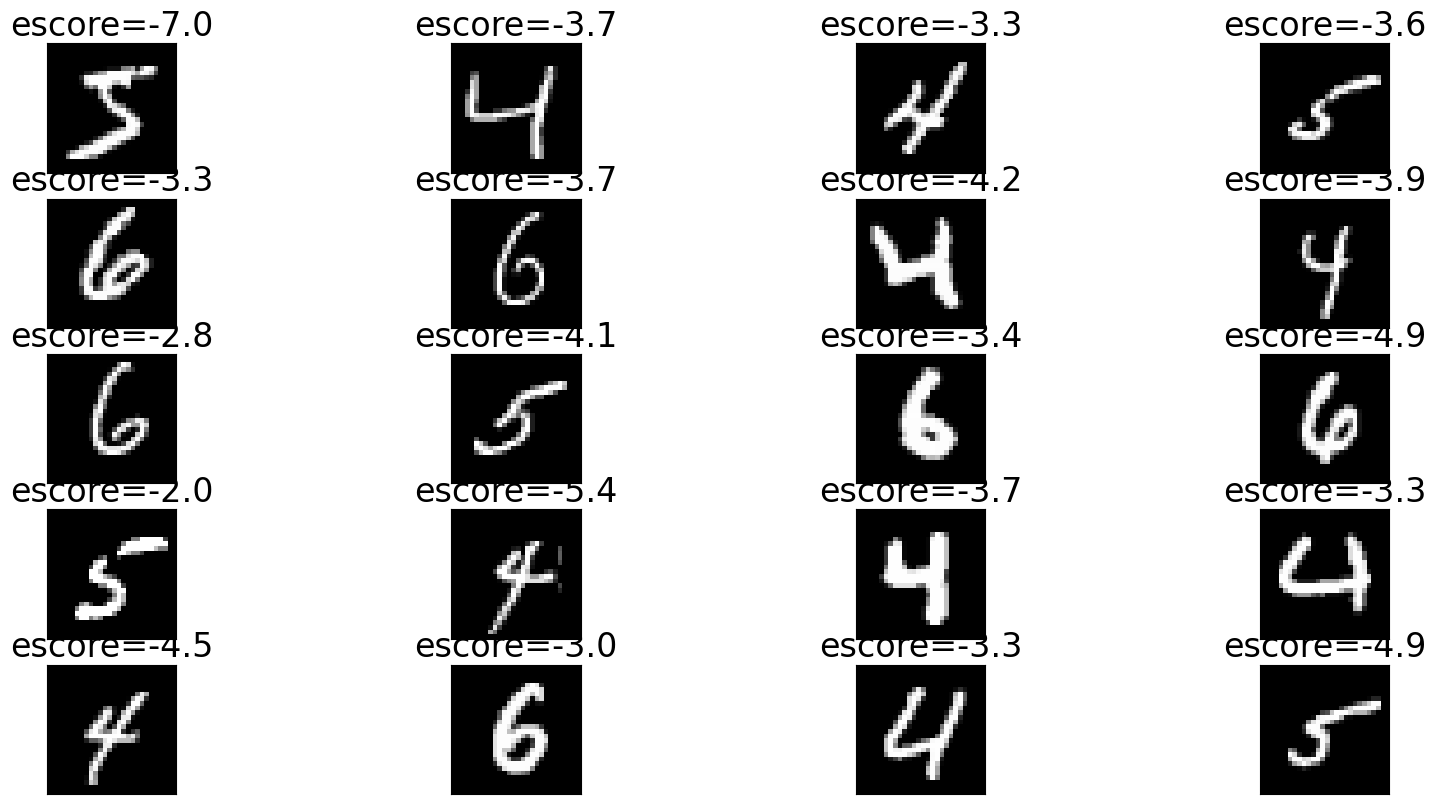

In [35]:
n = 20 # the number of data to be plotted
plt.figure(figsize=(20, 40)) # total figure size

for i in range(n):
    input_image = outlier_dataset[i][0].to(device)

    pred_escore = Escore(best_model(input_image.unsqueeze(0))[0]).cpu().detach().squeeze().numpy()
    ax = plt.subplot(n, 4, i+1)
    plt.imshow(input_image[0].cpu()) # show input image
    plt.title(f'escore={pred_escore:>0.1f}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

## 9. t-SNE visualization
Here, we visualize the feature space using t-SNE visualization tool

In [ ]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne1 = TSNE(2, verbose=1) #2D visualization
tsne_proj1 = tsne1.fit_transform(best_features1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3584 samples in 0.001s...
[t-SNE] Computed neighbors for 3584 samples in 0.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3584
[t-SNE] Computed conditional probabilities for sample 2000 / 3584
[t-SNE] Computed conditional probabilities for sample 3000 / 3584
[t-SNE] Computed conditional probabilities for sample 3584 / 3584
[t-SNE] Mean sigma: 2.285389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.620682
[t-SNE] KL divergence after 1000 iterations: 1.328600


/tmp/ipykernel_1375241/883910731.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


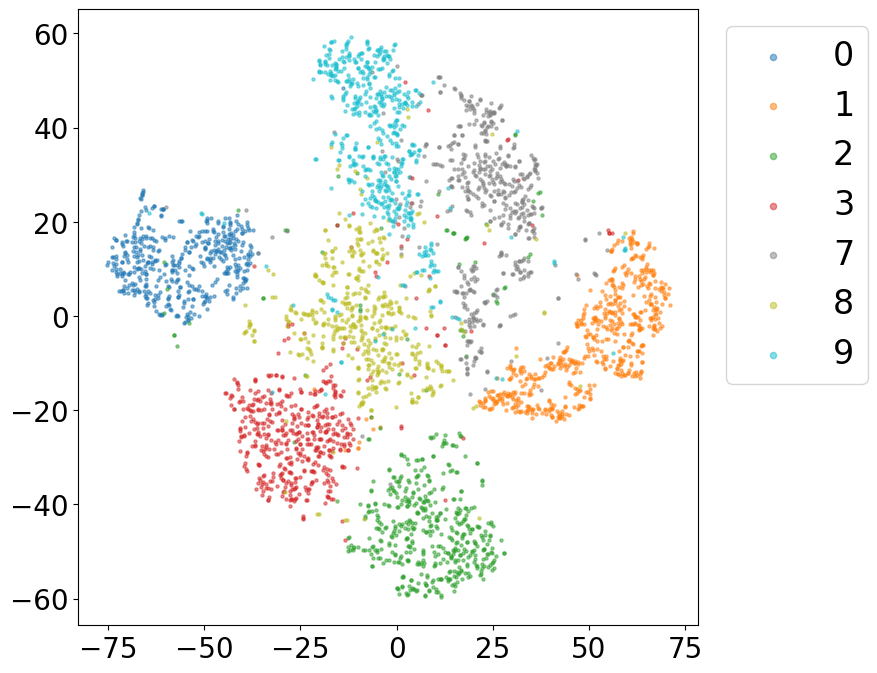

In [ ]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = total_labels1==ilabel
    ax.scatter(tsne_proj1[indices,0],tsne_proj1[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()

In [46]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne2 = TSNE(2, verbose=1) #2D visualization
tsne_proj2 = tsne2.fit_transform(best_features2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3584 samples in 0.000s...
[t-SNE] Computed neighbors for 3584 samples in 0.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3584
[t-SNE] Computed conditional probabilities for sample 2000 / 3584
[t-SNE] Computed conditional probabilities for sample 3000 / 3584
[t-SNE] Computed conditional probabilities for sample 3584 / 3584
[t-SNE] Mean sigma: 2.285389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.620567
[t-SNE] KL divergence after 1000 iterations: 1.328482


/tmp/ipykernel_1375241/413220616.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


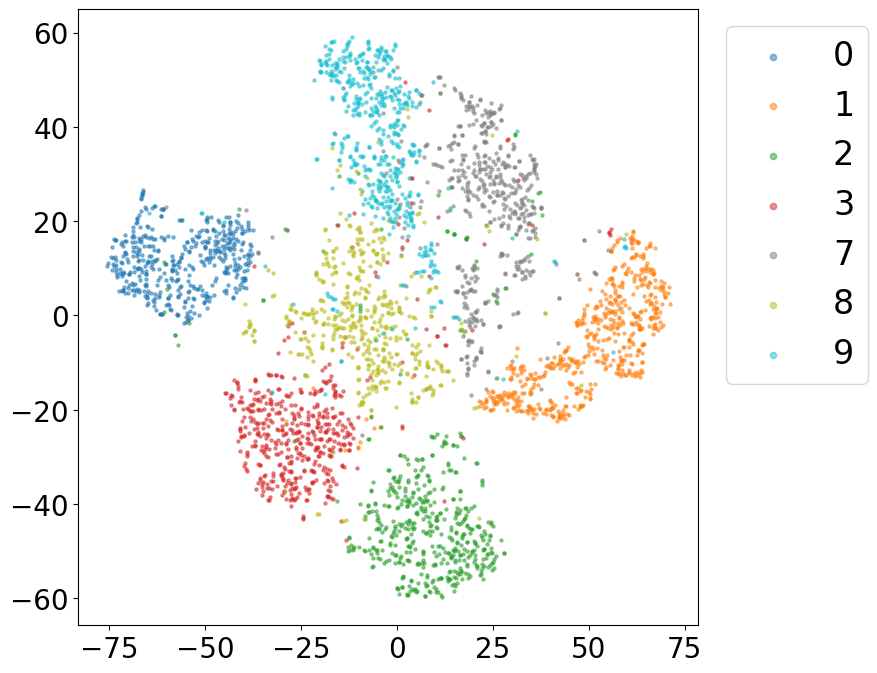

In [47]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = total_labels2==ilabel
    ax.scatter(tsne_proj2[indices,0],tsne_proj2[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()

In [44]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne3 = TSNE(2, verbose=1) #2D visualization
tsne_proj3 = tsne3.fit_transform(best_features3)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3584 samples in 0.000s...
[t-SNE] Computed neighbors for 3584 samples in 0.695s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3584
[t-SNE] Computed conditional probabilities for sample 2000 / 3584
[t-SNE] Computed conditional probabilities for sample 3000 / 3584
[t-SNE] Computed conditional probabilities for sample 3584 / 3584
[t-SNE] Mean sigma: 2.285389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.620766
[t-SNE] KL divergence after 1000 iterations: 1.328591


/tmp/ipykernel_1375241/2058672287.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


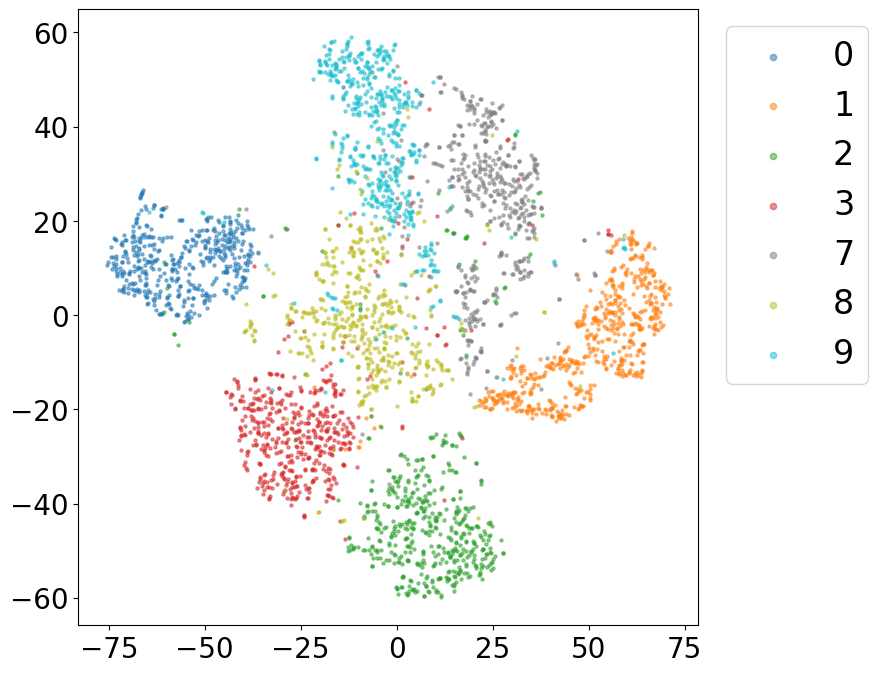

In [45]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = total_labels3==ilabel
    ax.scatter(tsne_proj3[indices,0],tsne_proj3[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()

### t-SNE visuliazation including OE

In [ ]:
all_features = np.vstack((best_features1,oe_features1))
all_labels = np.hstack((total_labels1,oe_labels1))

In [ ]:
# Create a two dimensional t-SNE projection of the feature embeddings
#tsne_all = TSNE(2, verbose=1) #2D visualization
#tsne_all_proj = tsne_all.fit_transform(all_features)

In [ ]:
# Plot those points as a scatter plot and label them based on the pred labels
# cmap = cm.get_cmap('tab10')
# fig, ax = plt.subplots(figsize=(8,8))
# TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM + OUTLIER_NUM
# num_categories = len(TOTAL_NUM)
# for ilabel in TOTAL_NUM:
#     indices = all_labels==ilabel
#     ax.scatter(tsne_all_proj[indices,0],tsne_all_proj[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
# ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
# plt.show()